In [12]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
#from langdetect import detect
import matplotlib.dates as md
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read in the data

In [13]:
fs = glob.glob('data/*/*')
fields = ['text', 'lang']
metrics = [f'{m}_count' 
           for m in ['like','quote','reply','retweet']]
processed_tws = []
for f in fs:
    tws = json.load(open(f))['data']
    for i in range(len(tws)):
        item = {k: tws[i][k] for k in fields}
        item.update({k: tws[i]['public_metrics'][k] for k in metrics})
        item.update({'created_at': tws[i]['created_at'][:10]})
        tws[i] = item
    processed_tws += tws

In [14]:
df = pd.DataFrame(processed_tws)
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)

### Tweet volume

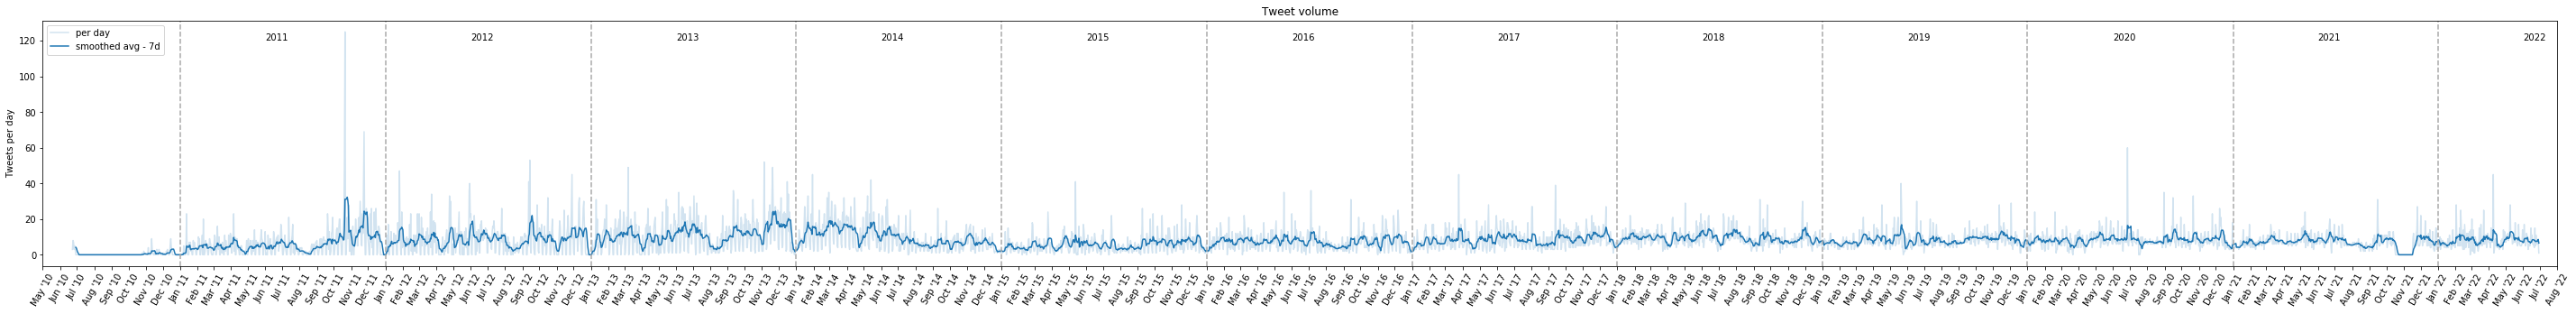

In [15]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (50,5), 'W': (50,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}
top_dict = {}
for freq in ['D']:
    fig, ax = plt.subplots(figsize=figsizes[freq])
    grouped = df.groupby(pd.Grouper(key='created_at', axis=0, freq=freq)).count().reset_index()
    top_dict[freq_dict[freq]] = grouped.sort_values(by='text', ascending=False).head(n=5)[['created_at', 'text']].to_records(index=False)
    grouped['smoothed'] = grouped['text'].rolling(7).mean()
    # Plot 
    sns.lineplot(data=grouped, x='created_at', y='text', 
                 alpha=.2, 
                 label='per day')
    sns.lineplot(data=grouped, x='created_at', y='smoothed', 
                 label='smoothed avg - 7d', 
                 color=sns.color_palette()[0])
    plt.ylabel(f'Tweets per {freq_dict[freq]}')
    plt.xlabel('')
    plt.title('Tweet volume')
    plt.xticks(rotation=60)
    # Make year boundaries
    for d in grouped.created_at.dt.year.unique()[1:]:
        plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
        plt.annotate(s=d, xy=(np.datetime64(f'{d}-06-01'),120), color='black')
    ax.xaxis.set_major_locator(md.MonthLocator())
    ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
    plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
    plt.savefig('figures/tweet_volume.pdf')
    plt.show()

In [16]:
print(df[df.created_at == np.datetime64(top_dict['day'][1][0])].text.tolist())
print(top_dict['day'][1][0])

['Air transport: #EC requests Austria, Germany, Italy and Luxembourg to comply with rules on airport charges  http://t.co/sVQ7iwfQ', 'Maritime safety:#EC requests #Italy to comply with new safety rules for passenger ships http://t.co/hMqNwrO7', 'Rail: #EC refers #Germany to Court of Justice over railway safety http://t.co/0Nfo9eAp', '#EC asks the #United Kingdom to pay due amounts of customs duties to #EU budget  http://t.co/qsjObEPR', 'Free movement of goods: #EC requests #Greece to facilitate the selling of "bake off" products  http://t.co/qH6GSk8m', 'Free movement of goods: #EC requests #Netherlands to comply with EU rules on firearms  http://t.co/3KCimGLY', "Working time: #EC requests #Belgium to end compulsory postponement of workers' annual leave http://t.co/U9GlQkPC", 'Free movement of workers: #EC requests #Italy to end discrimination in recruiting university professors  http://t.co/PFJGDfLI', 'Social Security: #EC requests #Spain to end refusal of European Health Insurance Car

Some of the peaks with highest volumes are related to live tweeting of #EUMFF negotiations, automated posting re: to activity on other websites (Storify), and other. 
Worth keeping in mind that tweet volume can be a major confounder with this data.

### Additional preprocessing
- flag retweets and tweets starting with mentions;
- strip links;
- not removing emojis, hashtags and mentions, for now - but could remove depending on which model we end up using.

In [17]:
def language_detection(s):
    try:
        return detect(s)
    except:
        return 'unk'

In [18]:
df['is_retweet'] = np.where(df['text'].str.startswith('RT'), 1, 0)
df['is_mention'] = np.where(df['text'].str.startswith('@'), 1, 0)
df['text'] = df['text'].str.replace(r'http.*', '', regex=True)
df = df[df['text'].str.len() > 0]
#df['lang_detected'] = df['text'].apply(language_detection)
#df[df['lang']!=df['lang_detected']]
df.to_csv('processed/all_tweets.csv', sep=',')

Breakdown of number of tweets per language

In [19]:
df = pd.read_csv('processed/all_tweets.csv', sep=',', index_col=0)
df.groupby('lang')['text'].count().reset_index().sort_values(by='text', ascending=False).rename({'text': 'count'}, axis=1)

,lang,count
9,en,32442
14,fr,828
7,de,207
10,es,155
31,und,122
19,it,81
26,ro,69
30,uk,47
24,pl,45
22,nl,37


Removing tweets not in English, it's mostly translations of English tweets. We know that Twitter's automatic language detection is not great, so double-checking with langdetect and only including tweets tagged as English by both the default tagger and langdetect.

In [20]:
df = df[(df['lang']=='en')] # & (df['lang_detected']=='en')]

### Train-test splits
Let's leave out a small dataset for pretraining of our language models. We pick a random set of tweets (if that does not show good results, we could consider balanced sampling over time).

In [21]:
import random
random.seed(42)

train_size = 3000
val_size = 500

train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * (df.shape[0] - train_size - val_size)
random.shuffle(train_test)
df['pretraining_splits'] = train_test

Great, now let's fine tune some language models on these tweets for better performance. 

In [23]:
from pretrain import Pretrainer
models = ['distilbert-base-uncased', 
          'distilroberta-base',
          'all-mpnet-base-v2', 
          'all-distilroberta-v1',
          'all-MiniLM-L12-v2']
for m in models:
    trainer = Pretrainer(m, df[df['lang']=='en'])
    trainer.compile()
    trainer.fit()
    trainer.save() # potentially pass name

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForMaskedLM: ['activation_13']
- This IS expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertForMaskedLM were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForMaskedLM for predictions without further training.


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

11/11 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - logits_loss: 0.0000e+00 - loss_loss: 0.0000e+00
[0.0, 0.0, 0.0]


TypeError: must be real number, not list

### Topic modeling
Let's move on to modeling the topic of the tweets. We'll try to compare different modeling strategies, and both pretrained and fine-tuned models.
Then, we'll try to get an idea of what the evolution of topics has been over time. 

In [ ]:
from octis.models.CTM import CTM
from octis.dataset.dataset import Dataset
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence

Now, let's compare this approach with a simpler topic modeling approach.

### Next steps
- Run name
- Fine-tune
- Topic modeling
- Engagement as a function of topic
- Collect comments, annotate emotions in comments, plot emotion of reactions as a function of topics
    - Also polarization?
- Topics & engagement as a function of emotions of EU Commission tweet